In [1]:
import pickle
import random
with open("new_copy_images.pkl", "rb") as fp:
    new_data = pickle.load(fp)
random.shuffle(new_data)

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]
 
import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
images = np.array([item[0] for item in new_data])
labels = np.array([item[1] for item in new_data])
new_data = []


In [4]:
images= np.expand_dims(images, axis=-1)
labels = np.expand_dims(labels, axis=-1)
images.shape, labels.shape

((1500, 1024, 1024, 1), (1500, 1))

In [5]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [6]:
num_classes = len(np.unique(y_train))  # Number of unique labels in y_train
input_shape = x_train[0].shape  # Take shape from the first image in x_train
input_shape, num_classes

((1024, 1024, 1), 3)

In [7]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (1200, 1024, 1024, 1) - y_train shape: (1200, 1)
x_test shape: (300, 1024, 1024, 1) - y_test shape: (300, 1)


In [8]:
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 32
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 224  # We'll resize input images to this size
patch_size = 10  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [11]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches
    
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 224 X 224
Patch size: 10 X 10
Patches per image: 484
Elements per patch: 100


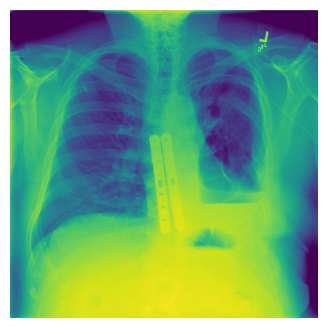

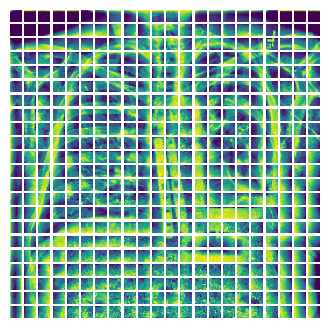

In [12]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [13]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [14]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [15]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_3_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 3 accuracy: {round(top_3_accuracy * 100, 2)}%")

    return history


In [16]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2057s 58s/step - accuracy: 0.3515 - loss: 3.0311 - top-3-accuracy: 1.0000 - val_accuracy: 0.4250 - val_loss: 1.1805 - val_top-3-accuracy: 1.0000
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2060s 60s/step - accuracy: 0.3749 - loss: 2.4214 - top-3-accuracy: 1.0000 - val_accuracy: 0.2917 - val_loss: 1.9014 - val_top-3-accuracy: 1.0000
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1651s 48s/step - accuracy: 0.4035 - loss: 2.0597 - top-3-accuracy: 1.0000 - val_accuracy: 0.5250 - val_loss: 1.0584 - val_top-3-accuracy: 1.0000
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1279s 37s/step - accuracy: 0.3736 - loss: 1.8389 - top-3-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.0559 - val_top-3-accuracy: 1.0000
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1380s 40s/step - accuracy: 0.3870 - loss: 1.6690 - top-3-accuracy: 1.0000 - val_accuracy: 0.4167 - val_loss: 1.0716 - val_top-3-accuracy: 1.0000
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1373s 41s/step - accuracy: 0.3870 - loss: 1.618

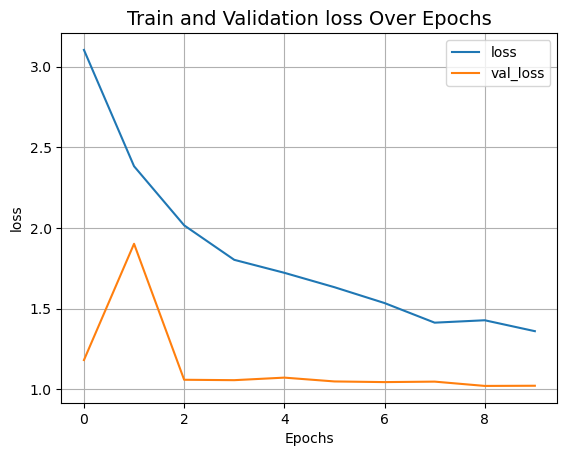

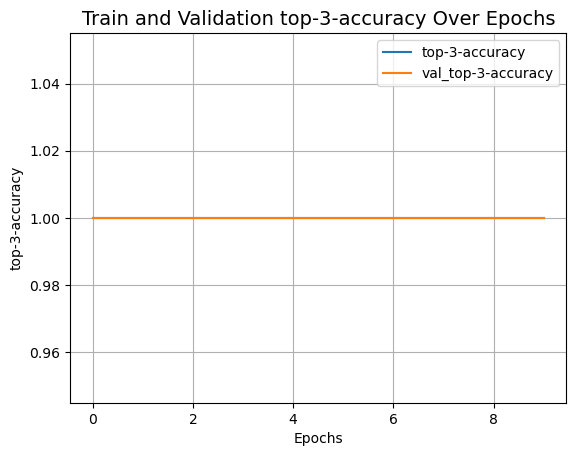

In [17]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-3-accuracy")

In [18]:
from sklearn.metrics import confusion_matrix
y_prediction = vit_classifier.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)

10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step
[[0.57692308 0.28387097 0.34453782]
 [0.26923077 0.48387097 0.14285714]
 [0.15384615 0.23225806 0.51260504]]


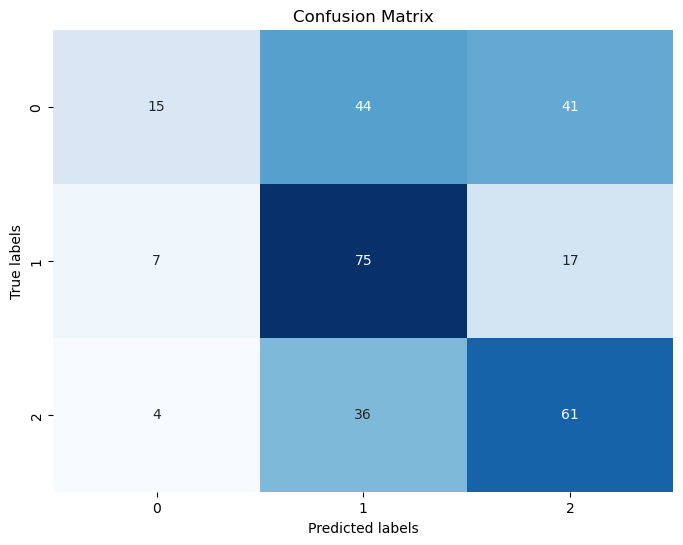

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Reshape y_true to match the shape of y_pred
y_test = np.squeeze(y_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_prediction)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [20]:
from sklearn.metrics import classification_report
# Compute classification report
report = classification_report(y_test, y_prediction)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.58      0.15      0.24       100
           1       0.48      0.76      0.59        99
           2       0.51      0.60      0.55       101

    accuracy                           0.50       300
   macro avg       0.52      0.50      0.46       300
weighted avg       0.52      0.50      0.46       300

